In [1]:
import pandas as pd
import numpy as np
import uuid
from datetime import datetime
from dateutil.relativedelta import relativedelta
# set the settingWithCopyWarning in Pandas to None
pd.options.mode.chained_assignment = None  # default='warn'
%matplotlib inline

#### The aim of this notebook is to generate product usage data from scratch. We generate data for 1000 users and simulate their behavior which can then we used for cohort analysis like creating retention curves. More here: http://josolnik.com/generating_product_usage_data.html

### 1. Defining the main parameters

In [2]:
# number of devices to generate data for
num_device_uuids = 1000

# number of months generated for each device
num_months = 20

# starting month of product usage data
start_month = '2016-01-01'

###  2. Generating device uuids and applying them to datetime data

In [3]:
# generating unique identifiers for each device
uuids = pd.Series([str(uuid.uuid4()) for i in range(1,num_device_uuids)])
user_data = pd.DataFrame()
user_data['device_uuid'] = pd.Series(uuids).repeat(num_months)
user_data =user_data.reset_index().drop('index', 1)

# example of two different device uuids (last row of first device, first row of second device)
user_data[19:21]

,device_uuid
19,176b4011-c2f6-4007-9e03-6eecb93d5982
20,e8aa1b74-b67b-4af7-8c3d-87b6f8382fa0


In [4]:
# defining starting and ending month for generating data
start_month_ts = pd.to_datetime(start_month)
end_month_ts = start_month_ts + relativedelta(months=+num_months - 1)
str(start_month_ts), str(end_month_ts)

('2016-01-01 00:00:00', '2017-08-01 00:00:00')

In [5]:
# months for which we will be generating data
months = pd.Series(pd.date_range(start_month_ts, end_month_ts, freq='MS'))
months

0    2016-01-01
1    2016-02-01
2    2016-03-01
3    2016-04-01
4    2016-05-01
5    2016-06-01
6    2016-07-01
7    2016-08-01
8    2016-09-01
9    2016-10-01
10   2016-11-01
11   2016-12-01
12   2017-01-01
13   2017-02-01
14   2017-03-01
15   2017-04-01
16   2017-05-01
17   2017-06-01
18   2017-07-01
19   2017-08-01
dtype: datetime64[ns]

In [6]:
# adding date column to the user data dataframe
user_data['date'] = pd.concat([months] * num_device_uuids, axis=0).reset_index().drop('index', 1)
user_data.head()

,device_uuid,date
0,176b4011-c2f6-4007-9e03-6eecb93d5982,2016-01-01
1,176b4011-c2f6-4007-9e03-6eecb93d5982,2016-02-01
2,176b4011-c2f6-4007-9e03-6eecb93d5982,2016-03-01
3,176b4011-c2f6-4007-9e03-6eecb93d5982,2016-04-01
4,176b4011-c2f6-4007-9e03-6eecb93d5982,2016-05-01


### 3. Generating usage features

In [7]:
# defining parameters for usage features (used later)
num_usage_features = 3
feature_usage_ratio = 0.8

### 3.1. Calculating feature ratios

In [8]:
# extracting all the unique device uuids from the main df
device_uuids = pd.Series(user_data['device_uuid'].unique())
user_data_with_usage = pd.DataFrame()
device_uuids[0:5]

0    176b4011-c2f6-4007-9e03-6eecb93d5982
1    e8aa1b74-b67b-4af7-8c3d-87b6f8382fa0
2    14353987-d52a-4a9d-a837-4df6a86fe1b1
3    0f180a18-2315-457c-a742-10140a93c9af
4    6264ad95-0958-4215-8714-b0b75e22630e
dtype: object

In [9]:
# generate random usage data for each feature and simulate dimishing usage per feature
# (each feature 80% of the previous one)
# example: F1 = 1, F2 = F1*0.8 = 0.8, F3 = F2*0.8 = 0.64

# extract the names for each feature based on the preset number of feature
features = ['feature' + str(i) for i in range(1,num_usage_features+1)]

usage_features_ratio = {}

# set the feature_ratio for the first feature (100%)
cur_feature = 1.0

# calculate the ratio for each feature
for feature in features:
    usage_features_ratio[feature] = float("{0:.1f}".format(cur_feature))
    cur_feature*= 0.8

print("Feature ratios: ", usage_features_ratio)

Feature ratios:  {'feature2': 0.8, 'feature1': 1.0, 'feature3': 0.6}


### 3.2. Assigning cohort groups to devices

##### When did the user start using the product? (How many months to remove from the beginning of devices' dataframe?)

In [10]:
# set the number of cohorts to be half of number of months of data (20 months = 10 cohorts)
num_cohorts = int(num_months / 2) 
num_cohorts

10

In [11]:
# assign cohorts to users randomly (when did the user first used the app?)
cohorts = pd.DataFrame()
cohorts['device_uuid'] = device_uuids
cohorts['cohort_group'] = np.random.randint(low=1, high=num_cohorts, size=num_device_uuids-1)
cohorts.head()

,device_uuid,cohort_group
0,176b4011-c2f6-4007-9e03-6eecb93d5982,8
1,e8aa1b74-b67b-4af7-8c3d-87b6f8382fa0,3
2,14353987-d52a-4a9d-a837-4df6a86fe1b1,8
3,0f180a18-2315-457c-a742-10140a93c9af,3
4,6264ad95-0958-4215-8714-b0b75e22630e,9


### 3.3. Adding cohort data

In [12]:
# convert a series of dataframes into a dataframe
# we need this when we get an output as a series for dataframes,
# each dataframe representing data for a specific device
def df_series_to_df(df_series):
    df = pd.concat([df for df in df_series], ignore_index=True)
    return(df)

In [13]:
# how many months to remove from the beginning of a dataframe?
def add_cohorts_to_df(device_uuid):
    
    # 1. slice user_data, extract device data for each user
    device_uuid_data = user_data[user_data['device_uuid'] == device_uuid]
    
    # 2. find cohort group of the device and delete all unnecessary months
    device_uuid_cohort_group = int(cohorts[cohorts['device_uuid'] == device_uuid]['cohort_group'])
    device_uuid_data = device_uuid_data[device_uuid_cohort_group:] 
    
    return(device_uuid_data)

In [14]:
# takes a while to run
user_data_with_cohort_groups_df = df_series_to_df(device_uuids.apply(add_cohorts_to_df))

In [15]:
user_data_with_cohort_groups_df.head()

,device_uuid,date
0,176b4011-c2f6-4007-9e03-6eecb93d5982,2016-09-01
1,176b4011-c2f6-4007-9e03-6eecb93d5982,2016-10-01
2,176b4011-c2f6-4007-9e03-6eecb93d5982,2016-11-01
3,176b4011-c2f6-4007-9e03-6eecb93d5982,2016-12-01
4,176b4011-c2f6-4007-9e03-6eecb93d5982,2017-01-01


In [16]:
# average number of months of usage per device_uuid
# down from 20 (deleted the rows where the user stopped using the product - churned)
avg_months_per_device_after_cohorts = round(len(user_data_with_cohort_groups_df) / len(device_uuids))
print("Average number of months per user after simulating cohorts:", avg_months_per_device_after_cohorts, \
     "(down from 20)")

Average number of months per user after simulating cohorts: 15 (down from 20)


### 3.4. Generating product usage data

In [17]:
# reseting the index
user_data_with_cohort_groups_df = user_data_with_cohort_groups_df.reset_index().drop('index', axis=1)

# generate usage for feature1
user_data_with_cohort_groups_df[features[0]] = pd.Series((
        np.random.randint(low=0, high=14, 
        size=len(user_data_with_cohort_groups_df))))


# generate usage for the remaining usage features (feature2 and feature3)
for feature in features[1:]:
        user_data_with_cohort_groups_df[feature] = user_data_with_cohort_groups_df[features[0]] * usage_features_ratio[feature]
        
user_data_with_cohort_groups_df.head()

,device_uuid,date,feature1,feature2,feature3
0,176b4011-c2f6-4007-9e03-6eecb93d5982,2016-09-01,13,10.4,7.8
1,176b4011-c2f6-4007-9e03-6eecb93d5982,2016-10-01,3,2.4,1.8
2,176b4011-c2f6-4007-9e03-6eecb93d5982,2016-11-01,11,8.8,6.6
3,176b4011-c2f6-4007-9e03-6eecb93d5982,2016-12-01,4,3.2,2.4
4,176b4011-c2f6-4007-9e03-6eecb93d5982,2017-01-01,12,9.6,7.2


### 3.5. Simulating churn behavior

##### When did the user stop using the product? (How many months to remove from the end of the devices' dataframe?)

#### 2 principles:
    1. Churner stays a churner (after a month of no usage the user doesn't use the product again)
    2. 50 % of users churn in month 1 (about 50% of users have 1 month of data, about 50% have more)

In [18]:
def simulating_churn(device_uuid):

    # set the churner to False
    churner = False
    
    # 50 % chance that the user churns in the first month
    churner_in_m1 = True if int(np.random.randint(low=0, high=2, size=1)) == 0 else False
    
    # get a slice of device_uuid data
    device_uuid_data = user_data_with_cohort_groups_df[user_data_with_cohort_groups_df['device_uuid'] == device_uuid]
    
    
    # if the user churns in month 1 then assign all of the months to 0
    # (except in month 0 when the user first used the product)
    if churner_in_m1:
        device_uuid_data.loc[device_uuid_data.index[1]:, features[0:]] = 0
        
    else:
    # if user didn't churn in the first month
        for index, row in device_uuid_data.iterrows():
        
            # did the user churn in this month?
            if row[features[0]] == 0:
                churner = True   

            # if user churned already set the value of all usage features to 0 for the remaining months
            if churner == True:
                device_uuid_data.loc[index, features[0:]] = 0
                
    # delete months when the user didn't use the product (churn months)
    device_uuid_data = device_uuid_data[device_uuid_data[features[0]] != 0]
    
    return(device_uuid_data)

In [19]:
user_data_with_usage_features_and_churn_df = df_series_to_df(device_uuids.apply(simulating_churn))
user_data_with_usage_features_and_churn_df.head()

,device_uuid,date,feature1,feature2,feature3
0,176b4011-c2f6-4007-9e03-6eecb93d5982,2016-09-01,13,10.4,7.8
1,e8aa1b74-b67b-4af7-8c3d-87b6f8382fa0,2016-04-01,2,1.6,1.2
2,14353987-d52a-4a9d-a837-4df6a86fe1b1,2016-09-01,7,5.6,4.2
3,14353987-d52a-4a9d-a837-4df6a86fe1b1,2016-10-01,11,8.8,6.6
4,14353987-d52a-4a9d-a837-4df6a86fe1b1,2016-11-01,5,4.0,3.0


In [20]:
# average number of months of usage per device_uuid
# down from 20 (deleted the rows where the user stopped using the product - churned)
avg_months_per_device_after_churn = round(len(user_data_with_usage_features_and_churn_df) / len(device_uuids))
print("Average number of months per user after simulating churn:", avg_months_per_device_after_churn, \
     "(down from 20)")

Average number of months per user after simulating churn: 5 (down from 20)


### 4. Generating categorical features

In [21]:
# defining categorical parameters
platforms = ['iOS', 'Android']
countries = ['NL', 'AU', 'FR']
user_registered = [False, True]

In [22]:
segmentation_features = {'platform': platforms,
                'user_registered': user_registered,
                'country': countries}
segmentation_features

{'country': ['NL', 'AU', 'FR'],
 'platform': ['iOS', 'Android'],
 'user_registered': [False, True]}

### 4.1. Generating categorical feature weights

In [23]:
# Defining weights for the likelihood of a categorical feature appearing

weights_2 = [0.7, 0.3]
weights_3 = [0.6, 0.3, 0.1]

# If there are two possible variants in a categorical variable (e.g. 'Android' and 'iOS') then the data generated will contain 70% of the first variant and 30% with the second variant
# If there are three possible variants in a categorical variable (e.g. 'NL', 'AU', 'FR') then the data generated will contain 60% of the first variant, 30% with the second variant and 10% with the third variant

### 4.2. Applying the categorical feature weights

In [24]:
def generating_categorical_features(device_uuid):
    
    device_uuid_feature_values_dict = {}
    
    for feature_name, feature_values in segmentation_features.items():

        # generate the random feature value
        # add code if you want to add features with > 3 values
        if len(feature_values) == 2:
            feature_weights = weights_2
        elif len(feature_values) == 3:
            feature_weights = weights_3
        
        # generate the feature value from assigned weights
        feature_value = np.random.choice(feature_values, p=feature_weights)
        
        # make a dict for feature_name
        device_uuid_feature_values_dict[feature_name] = feature_value
        
        
        
    # make a df with segmentation features for the device_uuid
    device_segm_features = pd.DataFrame(list(device_uuid_feature_values_dict.items())).T
    device_segm_features.columns = device_segm_features.iloc[0]
    device_segm_features['device_uuid'] = device_uuid
    device_segm_features = device_segm_features.reindex(device_segm_features.index.drop(0))
    
    return(device_segm_features)

In [25]:
segmentation_features_df = df_series_to_df(device_uuids.apply(generating_categorical_features))
segmentation_features_df = segmentation_features_df.set_index('device_uuid').reset_index()
segmentation_features_df.head()

,device_uuid,country,platform,user_registered
0,176b4011-c2f6-4007-9e03-6eecb93d5982,AU,iOS,False
1,e8aa1b74-b67b-4af7-8c3d-87b6f8382fa0,FR,Android,False
2,14353987-d52a-4a9d-a837-4df6a86fe1b1,AU,Android,True
3,0f180a18-2315-457c-a742-10140a93c9af,NL,iOS,False
4,6264ad95-0958-4215-8714-b0b75e22630e,FR,iOS,True


##  5. Merging all features into the final dataframe

In [26]:
def merge_all_features(device_uuid):
    
    # extract device data from the main df (which includes usage data)
    device_uuid_df = user_data_with_usage_features_and_churn_df[user_data_with_usage_features_and_churn_df['device_uuid'] == device_uuid]
    # extract device data for segmentation features data
    device_seg_feature_values_df = segmentation_features_df[segmentation_features_df['device_uuid'] == device_uuid]
    
    # assign the values of segmentation features to the main df
    # works but don't understand it well enough to simply if further
    for seg_feature_name in device_seg_feature_values_df.columns[1:]:
        device_uuid_df[seg_feature_name] = device_seg_feature_values_df[seg_feature_name][int(device_seg_feature_values_df[seg_feature_name].index.values)]

    return(device_uuid_df)

In [27]:
final_df = df_series_to_df(device_uuids.apply(merge_all_features))
final_df.head()

,device_uuid,date,feature1,feature2,feature3,country,platform,user_registered
0,176b4011-c2f6-4007-9e03-6eecb93d5982,2016-09-01,13,10.4,7.8,AU,iOS,False
1,e8aa1b74-b67b-4af7-8c3d-87b6f8382fa0,2016-04-01,2,1.6,1.2,FR,Android,False
2,14353987-d52a-4a9d-a837-4df6a86fe1b1,2016-09-01,7,5.6,4.2,AU,Android,True
3,14353987-d52a-4a9d-a837-4df6a86fe1b1,2016-10-01,11,8.8,6.6,AU,Android,True
4,14353987-d52a-4a9d-a837-4df6a86fe1b1,2016-11-01,5,4.0,3.0,AU,Android,True


## 6. Checking simulation output in our final dataframe

#### Did we generate the data that we intended to?

Why? Law of large numbers: The average of the results obtained from a large number of trials should be close to the expected value, and will tend to become closer as more trials are performed) - <a href="https://en.wikipedia.org/wiki/Law_of_large_numbers"> More on that </a> 

### 6.1. Usage features

In [40]:
final_df.groupby(['user_registered']).mean()

,feature1,feature2,feature3
user_registered,,,
False,7.005252,5.604202,4.203151
True,7.171084,5.736867,4.302651


In [37]:
print("Feature 1 / Feature 2:", int((final_df[features[1]].mean() / final_df[features[0]].mean())*100), "%", \
     "(expected value is 80%)")

Feature 1 / Feature 2: 79 % (expected value is 80%)


In [38]:
print("Feature 2 / Feature 3:", int((final_df[features[2]].mean() / final_df[features[1]].mean())*100), "%" \
      , "(expected value is 80%)")

Feature 2 / Feature 3: 75 % (expected value is 80%)


### 6.2. Segmentation features

#### User registered?

In [79]:
print((final_df['user_registered'].sum() / len(final_df['user_registered'])*100).astype(int), \
      "% users are registered (expected value is 30%)")

32 % users are registered (expected value is 30%)


#### Country? 

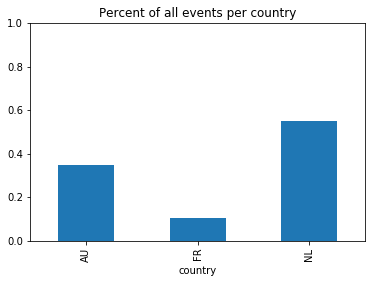

In [88]:
(final_df.groupby('country')['device_uuid'].count()/ len(final_df)).plot(kind='bar', ylim=(0,1), title="Percent of all events per country");

### 6.3. Churn simulation

In [89]:
# number of m1 users / number of non-m2 users should be close to 50/50
m1_users = (user_data_with_usage_features_and_churn_df.groupby('device_uuid')['date'].count() == 1).sum()
non_m1_users = (user_data_with_usage_features_and_churn_df.groupby('device_uuid')['date'].count() != 1).sum()
print("Number of m1 churners / Number of non-m1 churners:", m1_users, "/", non_m1_users)

Number of m1 churners / Number of non-m1 churners: 489 / 455


In [90]:
# checking that 50% of users churn in the first month
m1_users = (final_df.groupby('device_uuid')['date'].count() == 1).sum()
print(((m1_users / len(device_uuids))*100).astype(int), "% of users churn in the first month", \
     ("(expected value is 50%)"))

48 % of users churn in the first month (expected value is 50%)


## 7. Export the final dataframe as a csv

In [34]:
# exporting the final dataframe for later usage
final_df.to_csv('generating_user_behavioral_data.csv')